In [1]:
#Import PyTorch and matplotlib
import torch
import torchvision
from torch import nn
from torchvision import transforms
from torch.utils.data import Dataset
import imageio.v3 as iio
import numpy as np
import matplotlib.pyplot as plt
import time
from pthflops import count_ops

vRead = iio.imread("c_elegans.mp4")
video = np.array(vRead)

#Check PyTorch version
torch.__version__


'1.13.1'

### SET GPU if possible
run in shell: 
CUDA_VISIBLE_DEVICES= {gpu#/#s}

In [2]:
print("Cuda available: ", torch.cuda.is_available())
if(torch.cuda.is_available()):
    torch.cuda.set_device("cuda:3")

    print("Is cuDNN version:", torch.backends.cudnn.version())

    print("cuDNN enabled: ", torch.backends.cudnn.enabled)

    print("Device count: ", torch.cuda.device_count())

    print("Current device: ", torch.cuda.current_device())

    print("Device name: ", torch.cuda.get_device_name(torch.cuda.current_device()))
#Setup device agnostic code (i.e use GPU if possible)
device = "cuda" if torch.cuda.is_available() else "cpu"
gpuNum = 1
print(device)

Cuda available:  True
Is cuDNN version: 8302
cuDNN enabled:  True
Device count:  4
Current device:  3
Device name:  NVIDIA TITAN X (Pascal)
cuda


In [3]:
#Video Metadata
import imageio.v3 as iio
props = iio.improps("c_elegans.mp4")
print("Shape (frames, w, h, RGB): \n" + str(props.shape))
print(props.dtype)

Shape (frames, w, h, RGB): 
(2484, 322, 344, 3)
uint8


### Encoding Image as a Tensor

In [4]:
#Input grid  (width_px, height_ px)
grid = torch.empty(props.shape[1], props.shape[2], 3).to(device)

# Create image tensor
frame = 0
image = torch.tensor(video[frame]).to(device)
image = image.type(torch.int32)

image.shape


torch.Size([322, 344, 3])

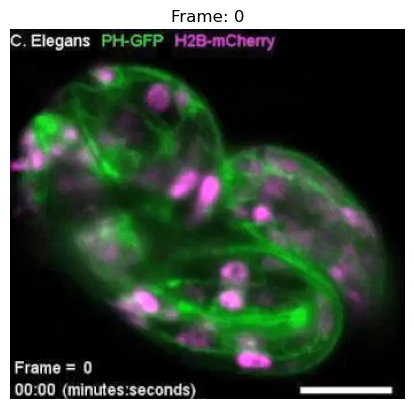

In [5]:
#test original identity output
plt.imshow(image.cpu())
plt.axis(False)
plt.title("Frame: " + str(frame));

### Dataset and DataLoader

In [9]:
import os
from torch.utils.data import DataLoader

class SingleImageDataset(Dataset):
    def __init__(self, image, transform=None, target_transform=None):
        self.image = image.type(torch.int32)
        self.transform = transform
        self.target_transform = target_transform
    def __len__(self):
        return int(image.shape[0]) * int(image.shape[1])
    def __getitem__(self, idx):
        row = idx // int(image.shape[1])
        col = idx % int(image.shape[1])
        pixel = torch.as_tensor(self.image[row][col]).type(torch.int32).cpu()
        #label = pixel
        return torch.as_tensor([row, col]).cpu(), pixel
training_data = SingleImageDataset(image)
#testing_data = None

#train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
#train_dataloader = DataLoader(testing_data, batch_size=32, shuffle=True)


In [10]:
#Test Dataloader
# First index: batch row list and batch col list
testGrid = torch.empty(props.shape[1], props.shape[2], 3).cpu()
testGrid = testGrid.type(torch.int32)


In [8]:
# FOR TESTING PURPOSES ONLY (Verifies sanity of dataset)
for batch in iter(train_dataloader):
    coords = batch[0]
    pixels = batch[1]
    for i in range(0, len(coords)):
        row = coords[i][0]
        col = coords[i][1]
        pixel = pixels[i]
        testGrid[row][col] = pixel
plt.imshow(testGrid.cpu());
plt.axis(False);

NameError: name 'train_dataloader' is not defined

### Main Model

In [42]:
import torch
from torch import nn
#from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
from torchvision import transforms

#Use seed for reproducibility
torch.manual_seed(42)
#Multilayer Percepetron Model 
class MLP(nn.Module):
    def __init__(self,
                 input_shape: int,
                 hidden_units: int,
                 output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
        nn.Linear(input_shape, hidden_units),
        nn.ReLU(),
        nn.Linear(hidden_units, hidden_units),
        nn.ReLU(),
        nn.Linear(hidden_units, hidden_units),
        nn.ReLU(),
        nn.Linear(hidden_units, hidden_units),
        nn.ReLU(),
        nn.Linear(hidden_units, hidden_units),
        nn.ReLU(),
        nn.Linear(hidden_units, hidden_units),
        nn.ReLU(),
        nn.Linear(hidden_units, hidden_units),
        nn.ReLU(),
        nn.Linear(hidden_units, hidden_units),
        nn.ReLU(),
        nn.Linear(hidden_units, hidden_units),
        nn.ReLU(),
        nn.Linear(hidden_units, output_shape),
        )
    #forward reconstruction
    def forward(self, X):
        return self.layer_stack(X.to(device))

### Instance of Model (for selected frame/image)

In [50]:
#Create an Instance and set loss function & optimizer
model_0 = MLP(input_shape=2, 
              hidden_units=128, 
              output_shape=3).to(device)


In [77]:


loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(params=model_0.parameters(),
                             lr=0.0001)
#list(model_0.parameters())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


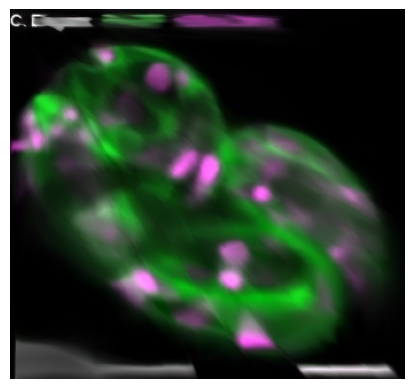

In [81]:
# Tests to reconstruct image for some frame
def test_loop():
    model_0.eval()
    testFrame = torch.zeros(image.shape[0], image.shape[1], 3).type(torch.int32)
    with torch.inference_mode():
        for i in range(0, int(image.shape[0])):
            for j in range(0, int(image.shape[1])):
                testFrame[i][j] = model_0(torch.tensor([1.0 * i, 1.0 * j])).type(torch.float32)
    plt.imshow(testFrame);
    plt.axis(False);
test_loop()

            

### Training Loop

In [79]:
from tqdm import tqdm

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True, pin_memory=True)

def trainLoop():
  #Track values
  #Loop through data
  for epoch in tqdm(range(0, 20)):
      ### Training
      model_0.train()
      #Process DataLoader Batch
      for batch in iter(train_dataloader):
        #print("new batch!")
        coords = torch.as_tensor(batch[0]).to(device)
        pixels = torch.as_tensor(batch[1]).to(device)
        #Loop through each pixel in batch
        
        X = torch.as_tensor(coords).type(torch.float32).to(device)
        y_train = torch.as_tensor(pixels).type(torch.float32).to(device)
        
        #1. Forward Pass
        y_pred = model_0(X).to(device)
        #2. Calculate Loss
        loss = loss_fn(y_pred, y_train)
        #3. Optimizer Zero Grad
        optimizer.zero_grad()
        #4. Backpropagation
        loss.backward()
        #5. Step optimizer
        optimizer.step()
        
      if epoch % 2 == 0:
        print(f"Epoch: {epoch} | Train loss: {loss}")
        #test_loop()

  print('Training finished')

In [80]:
trainLoop()

  5%|▌         | 1/20 [00:14<04:40, 14.76s/it]

Epoch: 0 | Train loss: 801.0043334960938


 15%|█▌        | 3/20 [00:42<03:57, 13.98s/it]

Epoch: 2 | Train loss: 69.361083984375


 25%|██▌       | 5/20 [01:11<03:36, 14.42s/it]

Epoch: 4 | Train loss: 183.29644775390625


 35%|███▌      | 7/20 [01:39<03:02, 14.05s/it]

Epoch: 6 | Train loss: 279.2877197265625


 45%|████▌     | 9/20 [02:09<02:39, 14.52s/it]

Epoch: 8 | Train loss: 277.81036376953125


 55%|█████▌    | 11/20 [02:37<02:09, 14.35s/it]

Epoch: 10 | Train loss: 807.4100341796875


 60%|██████    | 12/20 [02:55<01:57, 14.66s/it]


KeyboardInterrupt: 

In [83]:
### Save Model State Dictionary
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "2D_image_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
MODEL_SAVE_PATH

#3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(),
           f=MODEL_SAVE_PATH)
print(MODEL_SAVE_PATH)

Saving model to: models/2D_image_model_0.pth
models/2D_image_model_0.pth


### Loading a Model

In [13]:
# To load in a saved state_dict we have to instantiate a new instance of our model class
#loaded_model_0 = MLP() # new instance!

#Load the saved state_dict of model_0 (this wil updated the new instance with the updated parameters.)
model_0.load_state_dict(torch.load(f='models/2D_image_model_0.pth'))

<All keys matched successfully>

### Check Size of Model

In [ ]:
# Check model size by summing parameters and state_dict
params_size = 0
for param in model_0.parameters():
    params_size += param.nelement() * param.element_size()
buffer_size = 0
for buffer in model_0.buffers():
    buffer_size += buffer.nelement() * buffer.element_size()

size_all_mb = (params_size + buffer_size) / 1024**2
imageSize = 8 * image.shape[0] * image.shape[1] * image.shape[2]
imageSizeMB = imageSize / (10**6)
perDecrease = (imageSizeMB - size_all_mb) / imageSizeMB
perDecrease *= 100
print('original image size(no compression): {:.3f}MB'.format(imageSizeMB))
print('model size: {:.3f}MB'.format(size_all_mb))
print('Percent decrease in memory size: {:.3f}%'.format(perDecrease))